<a href="https://colab.research.google.com/github/Selva-Subramanian/Zomato-restaurant-clustering-Sentiment-Analysis/blob/main/ZOMATO_RESTAURANT_CLUSTERING_AND_SENTIMENT_ANALYSIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Problem Statement**

Zomato is an Indian restaurant aggregator and food delivery start-up founded by Deepinder Goyal and Pankaj Chaddah in 2008. Zomato provides information, menus and user-reviews of restaurants, and also has food delivery options from partner restaurants in select cities.

India is quite famous for its diverse multi cuisine available in a large number of restaurants and hotel resorts, which is reminiscent of unity in diversity. Restaurant business in India is always evolving. More Indians are warming up to the idea of eating restaurant food whether by dining outside or getting food delivered. The growing number of restaurants in every state of India has been a motivation to inspect the data to get some insights, interesting facts and figures about the Indian food industry in each city. So, this project focuses on analysing the Zomato restaurant data for each city in India.

The Project focuses on Customers and Company, you have  to analyze the sentiments of the reviews given by the customer in the data and made some useful conclusion in the form of Visualizations. Also, cluster the zomato restaurants into different segments. The data is vizualized as it becomes easy to analyse data at instant. The Analysis also solve some of the business cases that can directly help the customers finding the Best restaurant in their locality and for the company to grow up and work on the fields they are currently lagging in.

This could help in clustering the restaurants into segments. Also the data has valuable information around cuisine and costing which can be used in cost vs. benefit analysis

Data could be used for sentiment analysis. Also the metadata of reviewers can be used for identifying the critics in the industry. 

# **Attribute Information**

## **Zomato Restaurant names and Metadata**
Use this dataset for clustering part

1. Name : Name of Restaurants

2. Links : URL Links of Restaurants

3. Cost : Per person estimated Cost of dining

4. Collection : Tagging of Restaurants w.r.t. Zomato categories

5. Cuisines : Cuisines served by Restaurants

6. Timings : Restaurant Timings

## **Zomato Restaurant reviews**
Merge this dataset with Names and Matadata and then use for sentiment analysis part

1. Restaurant : Name of the Restaurant

2. Reviewer : Name of the Reviewer

3. Review : Review Text

4. Rating : Rating Provided by Reviewer

5. MetaData : Reviewer Metadata - No. of Reviews and followers

6. Time: Date and Time of Review

7. Pictures : No. of pictures posted with review

In [ ]:
# mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### <b> Importing the required libraries

In [74]:
# for numerical computation
import numpy as np
import math
# for data manipulation 
import pandas as pd

# for plotting visuals
import matplotlib.pyplot as plt 
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline

# Exploratory Data Analysis
from wordcloud import WordCloud
from prettytable import PrettyTable

# model building
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [ ]:
# load the dataset
working_dir_path = '/content/drive/MyDrive/Colab Notebooks/AlmaBetter Notebooks/Capstone projects/CP4 - Unsupervised - Clustering/'
df1 = pd.read_csv(working_dir_path + 'Zomato Restaurant names and Metadata.csv')
df2 = pd.read_csv(working_dir_path + 'Zomato Restaurant reviews.csv')

### <b> Data Inspection

In [ ]:
# sample of the dataset
df1.head()

,Name,Links,Cost,Collections,Cuisines,Timings
0,Beyond Flavours,https://www.zomato.com/hyderabad/beyond-flavou...,800,"Food Hygiene Rated Restaurants in Hyderabad, C...","Chinese, Continental, Kebab, European, South I...","12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)"
1,Paradise,https://www.zomato.com/hyderabad/paradise-gach...,800,Hyderabad's Hottest,"Biryani, North Indian, Chinese",11 AM to 11 PM
2,Flechazo,https://www.zomato.com/hyderabad/flechazo-gach...,"1,300","Great Buffets, Hyderabad's Hottest","Asian, Mediterranean, North Indian, Desserts","11:30 AM to 4:30 PM, 6:30 PM to 11 PM"
3,Shah Ghouse Hotel & Restaurant,https://www.zomato.com/hyderabad/shah-ghouse-h...,800,Late Night Restaurants,"Biryani, North Indian, Chinese, Seafood, Bever...",12 Noon to 2 AM
4,Over The Moon Brew Company,https://www.zomato.com/hyderabad/over-the-moon...,"1,200","Best Bars & Pubs, Food Hygiene Rated Restauran...","Asian, Continental, North Indian, Chinese, Med...","12noon to 11pm (Mon, Tue, Wed, Thu, Sun), 12no..."


In [ ]:
# brief info of the dataset 
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         105 non-null    object
 1   Links        105 non-null    object
 2   Cost         105 non-null    object
 3   Collections  51 non-null     object
 4   Cuisines     105 non-null    object
 5   Timings      104 non-null    object
dtypes: object(6)
memory usage: 5.0+ KB


In [ ]:
# brief description of the dataset
pd.set_option('display.max_rows', None)
df1.describe()

,Name,Links,Cost,Collections,Cuisines,Timings
count,105,105,105,51,105,104
unique,105,105,29,42,92,77
top,Aromas@11SIX,https://www.zomato.com/hyderabad/gal-punjab-di...,500,Food Hygiene Rated Restaurants in Hyderabad,"North Indian, Chinese",11 AM to 11 PM
freq,1,1,13,4,4,6


In [ ]:
# columns in the datset
df1.columns

Index(['Name', 'Links', 'Cost', 'Collections', 'Cuisines', 'Timings'], dtype='object')

#### All restaurants have links and it is not much useful so let's just drop it. 


In [ ]:
# Drop columns
df1 = df1.drop(['Links'], axis=1)

In [ ]:
# replace null values with a string
df1 = df1.fillna('no info')
df1['Timings'][30] = 'no info'

In [ ]:
# change datatype of 'Cost' feature
df1['Cost'] = df1['Cost'].apply(lambda x: int(x.replace(',','')))

In [ ]:
# formatting the string in  Timings feature
word_list = [[['noon','Noon','PM'],['p.m.']],[['midnight','Midnight','AM'],['a.m.']]]
for i in word_list:
  j = i[1][0]
  for k in i[0]:
    df1['Timings'] = df1['Timings'].str.replace(k,j)

### <b> Exploratory Data Analysis

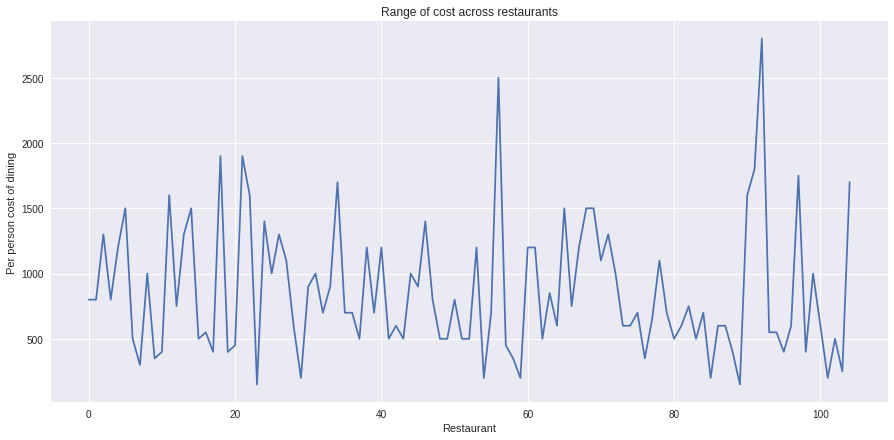

min: 150.0, IQR1:500.0, avg:700.0, IQR3: 1200.0, max: 2800.0


In [ ]:
# Analysis of the feature 'Cost'
plt.figure(figsize=(15,7))
df1['Cost'].plot(kind='line')
plt.title("Range of cost across restaurants")
plt.xlabel("Restaurant")
plt.ylabel("Per person cost of dining")
plt.show()
print(f"min: {df1['Cost'].describe()[3]}, IQR1:{df1['Cost'].describe()[4]}, avg:{df1['Cost'].describe()[5]}, IQR3: {df1['Cost'].describe()[6]}, max: {df1['Cost'].describe()[7]}")

#### Most of the restaurants cost of dining per person lies in the range of 500 and 1200 with minimum cost of dining per person at 150 and maximum at 2800 and average cost at 700.

##### <b> Unique values in our features





In [ ]:
# initialize empty lists
Unique_Collections = []
Unique_Cuisines = []

# features list
unique_list = [Unique_Collections, Unique_Cuisines]

# logic to extract unique values in the features
sum = 0
for i in df1.columns[2:-1]:
  l = unique_list[sum]
  sum += 1
  for j in range(len(df1[i])):
    for k in list(df1[i])[j].split(','):
      if k not in l and k[1:] not in l:
        if k[0]==' ':
          l.append(k[1:])
        else:
          l.append(k)

# number of unique items in the features
print(f"Total unique values in the feature 'Cost' is {len(df1['Cost'].value_counts())}\n")
for n,m in enumerate(df1.columns[2:-1]):
  print(f"Total unique values in the feature '{m}' is {len(unique_list[n])}\n")

Total unique values in the feature 'Cost' is 29

Total unique values in the feature 'Collections' is 38

Total unique values in the feature 'Cuisines' is 44



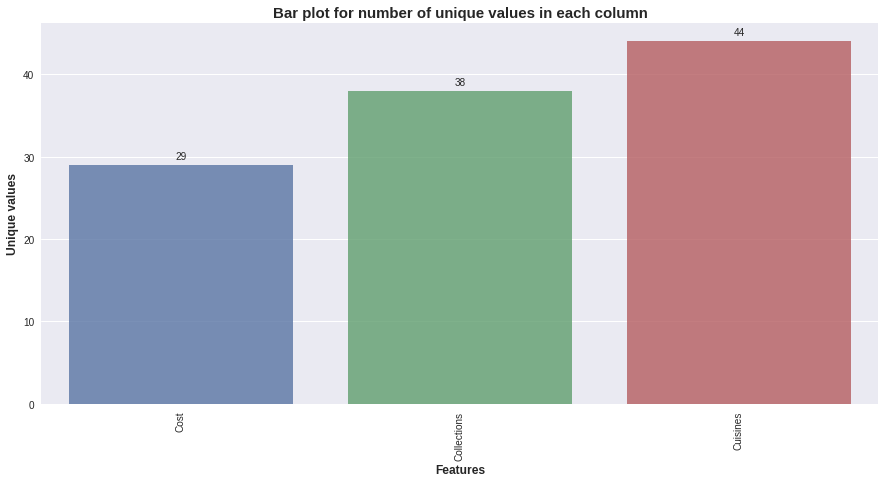

In [72]:
#Counting unique value of features
feature_names = ['Cost', 'Collections', 'Cuisines']
cost = len(df1['Cost'].value_counts())
collections = len(unique_list[0])
cuisines = len(unique_list[1])
feature_count = [cost, collections, cuisines]
f, ax = plt.subplots(1,1, figsize=(15,7))

splot = sns.barplot(x=feature_names, y=feature_count, alpha=0.8)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.title('Bar plot for number of unique values in each column',weight='bold', size=15)
plt.ylabel('Unique values', size=12, weight='bold')
plt.xlabel('Features', size=12, weight='bold')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# count of unique items in the features
features = ['Collections', 'Cuisines']

# initialize empty dictionaries
unique_count = {}
m = {}

# update unique values of 'Cost' and its frequency of occurence
for l in df1['Cost'].unique():
  m[l] = list(df1['Cost'].values).count(l)
unique_count['Cost'] = m
sum = 0

# initialize empty lists
collections_feature_list = []
cuisines_feature_list = []

# update unique values of 'Collections' and 'Cuisines' 
for i in unique_list:
  if i == unique_list[0]:
    df1[features[sum]] = df1[features[sum]].apply(lambda x: x.split(','))
    df1[features[sum]].apply(lambda x: collections_feature_list.extend(x))
    collections_feature_list = [x[1:] if x[0]==' ' else x[:] for x in collections_feature_list]
  else:
    df1[features[sum]] = df1[features[sum]].apply(lambda x: x.split(','))
    df1[features[sum]].apply(lambda x: cuisines_feature_list.extend(x))
    cuisines_feature_list = [x[1:] if x[0]==' ' else x[:] for x in cuisines_feature_list]
  
  # empty dict for 'Collections' and 'Cuisines'
  k = {}
  # update frequency of occurence
  for j in i:
    if i == unique_list[0]:
      k[j] = collections_feature_list.count(j)
    else:
      k[j] = cuisines_feature_list.count(j)  
  unique_count[features[sum]] = k
  feature_list = []
  sum += 1  

#### *Top 10 most frequent values of the features*

In [ ]:
# create a table for a better visual
table = PrettyTable(['SL', 'Cost','Collections', 'Cuisines'])
for i in range(1,11):
  table.add_row([i, sorted(unique_count['Cost'].items(), key=lambda x: x[1],reverse = True)[i], sorted(unique_count['Collections'].items(), key=lambda x: x[1], reverse = True)[i], sorted(unique_count['Cuisines'].items(), key=lambda x: x[1], reverse = True)[i]])
table

SL,Cost,Collections,Cuisines
1,"(600, 10)","('Great Buffets', 11)","('Chinese', 43)"
2,"(700, 8)","('Food Hygiene Rated Restaurants in Hyderabad', 8)","('Continental', 21)"
3,"(1200, 7)","('Live Sports Screenings', 7)","('Biryani', 16)"
4,"(1000, 6)","(""Hyderabad's Hottest"", 7)","('Asian', 15)"
5,"(400, 6)","('Corporate Favorites', 6)","('Fast Food', 15)"
6,"(800, 5)","('Top-Rated', 5)","('Italian', 14)"
7,"(1500, 5)","('Gold Curated', 5)","('Desserts', 13)"
8,"(200, 5)","('Trending This Week', 5)","('South Indian', 9)"
9,"(1300, 4)","('Best Bars & Pubs', 4)","('Bakery', 7)"
10,"(350, 3)","('Sunday Brunches', 4)","('Kebab', 6)"


In [ ]:
# text for word cloud generation
features = ['Collections', 'Cuisines']

# text corpus of 'Collections' and 'Cuisines'
for i in features:
  if i == 'Collections': 
    collections_feature_list_wo_no_info = []
    for j in collections_feature_list:
      if j != 'no info':
        collections_feature_list_wo_no_info.append(j)
    for n, m in enumerate(collections_feature_list_wo_no_info):
      if m in ['North Indian', 'South Indian']:
        if m == 'North Indian':
          collections_feature_list_wo_no_info[n] = 'NorthIndian'
        else:
          collections_feature_list_wo_no_info[n] = 'SouthIndian'
    collections_text = ','.join(collections_feature_list_wo_no_info)
  else:
    cuisines_text = ','.join(cuisines_feature_list)
    
# text corpus of 'Cost'
cost_text = df1['Cost'].value_counts()
cost_text.index = cost_text.index.map(str)

#### *Word cloud for the feature* ***'Cost'***

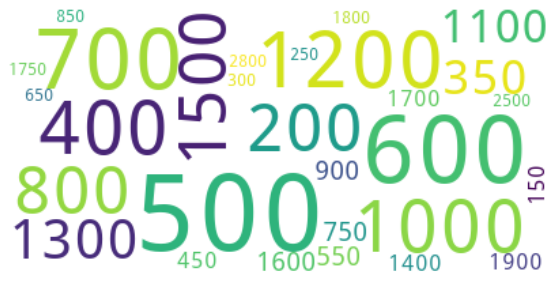

In [ ]:
# Creating word_cloud with text as argument in .generate_from_frequencies() method
word_cloud = WordCloud(collocations = False, background_color = 'white').generate_from_frequencies(cost_text)

# Display the generated Word Cloud
plt.figure(figsize=(15,5))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### *Word cloud for the feature* ***'Collections'*** 

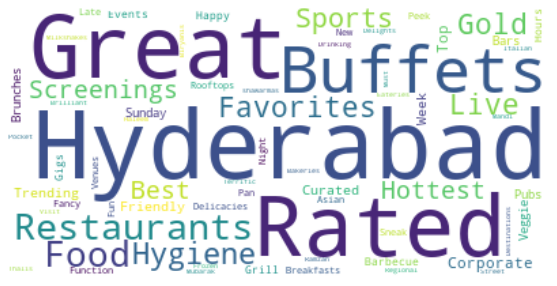

In [ ]:
# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(collections_text)

# Display the generated Word Cloud
plt.figure(figsize=(15,5))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### *Word cloud for the feature* ***'Cuisines'***

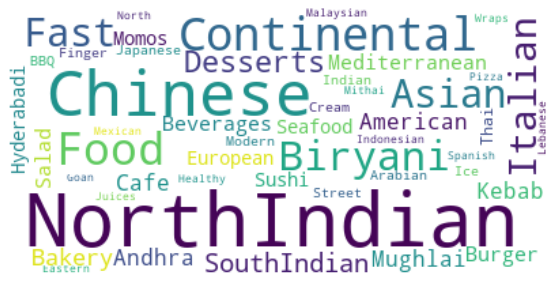

In [ ]:
# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(cuisines_text)

# Display the generated Word Cloud
plt.figure(figsize=(15,5))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### <b> Feature Engineering

In [ ]:
df1.head()

,Name,Cost,Collections,Cuisines,Timings
0,Beyond Flavours,800,"[Food Hygiene Rated Restaurants in Hyderabad, ...","[Chinese, Continental, Kebab, European, So...","12p.m. to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)"
1,Paradise,800,[Hyderabad's Hottest],"[Biryani, North Indian, Chinese]",11 a.m. to 11 p.m.
2,Flechazo,1300,"[Great Buffets, Hyderabad's Hottest]","[Asian, Mediterranean, North Indian, Desserts]","11:30 a.m. to 4:30 p.m., 6:30 p.m. to 11 p.m."
3,Shah Ghouse Hotel & Restaurant,800,[Late Night Restaurants],"[Biryani, North Indian, Chinese, Seafood, ...",12 p.m. to 2 a.m.
4,Over The Moon Brew Company,1200,"[Best Bars & Pubs, Food Hygiene Rated Restaur...","[Asian, Continental, North Indian, Chinese,...","12p.m. to 11pm (Mon, Tue, Wed, Thu, Sun), 12p...."


#### Clustering is based on similarity which is measured using distance, so it is necessary to have numerical(continuous) columns so as to quantify distance and compute similarity. Let's engineer such features. 

In [ ]:
df1['Timings'] = df1['Timings'].apply(lambda x: x.split(','))

In [64]:
df1['Timings']

0       [12p.m. to 3:30pm,  6:30pm to 11:30pm (Mon-Sun)]
1                                   [11 a.m. to 11 p.m.]
2       [11:30 a.m. to 4:30 p.m.,  6:30 p.m. to 11 p.m.]
3                                    [12 p.m. to 2 a.m.]
4      [12p.m. to 11pm (Mon,  Tue,  Wed,  Thu,  Sun),...
5      [12p.m. to 3:30p.m.,  4p.m. to 6:30p.m.,  7p.m...
6                                    [7 a.m. to 10 p.m.]
7                                   [12 p.m. to 12 a.m.]
8                                   [12 p.m. to 12 a.m.]
9      [10 a.m. to 1 a.m. (Mon-Thu),  10 a.m. to 1:30...
10         [12 p.m. to 3:30 p.m.,  7 p.m. to 10:30 p.m.]
11      [12 p.m. to 3:30 p.m.,  6:30 p.m. to 11:30 p.m.]
12                                [11:30 a.m. to 1 a.m.]
13                          [12p.m. to 12a.m. (Mon-Sun)]
14      [12 p.m. to 4:30 p.m.,  6:30 p.m. to 11:30 p.m.]
15                                  [11 a.m. to 11 p.m.]
16                               [12 p.m. to 10:30 p.m.]
17                             

In [ ]:
count = 0
for i in df1['Timings']:
  if len(i) == 2:
    count += 1 

In [ ]:
count

26

In [88]:
# Silhouette score
X = df1['Cost'].values.reshape(-1,1)
scaler = StandardScaler()
X = scaler.fit_transform(X)
range_n_clusters = [2,3,4,5,6,7,8,9,10,11,12,13,14,15]
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(X)
    centers = clusterer.cluster_centers_

    score = silhouette_score(X, preds)
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.6512067586634858
For n_clusters = 3, silhouette score is 0.5903958298192413
For n_clusters = 4, silhouette score is 0.5913183347879868
For n_clusters = 5, silhouette score is 0.5586802635046747
For n_clusters = 6, silhouette score is 0.5891612594437148
For n_clusters = 7, silhouette score is 0.5809866991600798
For n_clusters = 8, silhouette score is 0.600719123275836
For n_clusters = 9, silhouette score is 0.6290756980228273
For n_clusters = 10, silhouette score is 0.6333059731530661
For n_clusters = 11, silhouette score is 0.6935110729683102
For n_clusters = 12, silhouette score is 0.6545133471024178
For n_clusters = 13, silhouette score is 0.6911504717911889
For n_clusters = 14, silhouette score is 0.6953376334512276
For n_clusters = 15, silhouette score is 0.7231577609748305


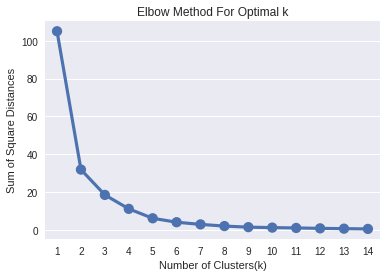

In [89]:
# elbow method for optimal k
sum_of_sq_dist = {}
for k in range(1,15):
    km = KMeans(n_clusters= k, init= 'k-means++', max_iter= 1000)
    km = km.fit(X)
    sum_of_sq_dist[k] = km.inertia_
    
#  plot the graph for the sum of square distance values and number of clusters
sns.pointplot(x = list(sum_of_sq_dist.keys()), y = list(sum_of_sq_dist.values()))
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [90]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)
y_kmeans= kmeans.predict(X)

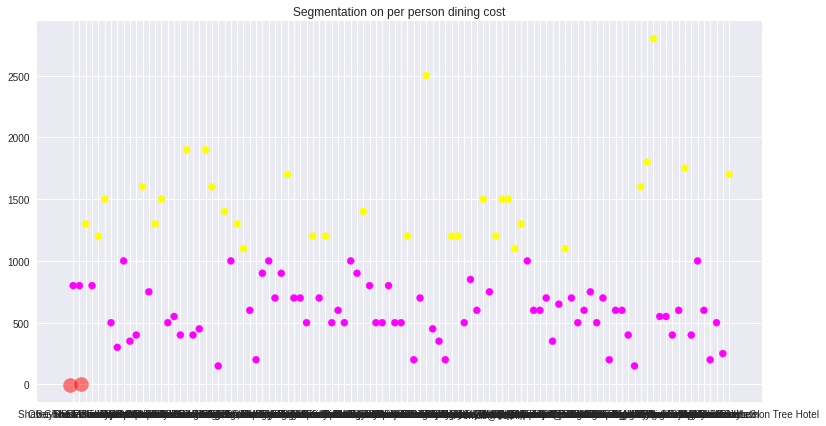

In [95]:
plt.figure(figsize=(13,7))
plt.title('Segmentation on per person dining cost')
plt.scatter(df1['Name'], df1['Cost'], c=y_kmeans, s=50, cmap='spring')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 0], c='red', s=200, alpha=0.5)

### <b> Kmodes for feature 'Timings'

In [ ]:
# !pip install kmodes
# from kmodes.kmodes import KModes

In [ ]:
# # Elbow curve to find optimal K
# cost = []
# K = range(1,5)
# for num_clusters in list(K):
#     kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5, verbose=1)
#     kmode.fit_predict(x)
#     cost.append(kmode.cost_)
    
# plt.plot(K, cost, 'bx-')
# plt.xlabel('No. of clusters')
# plt.ylabel('Cost')
# plt.title('Elbow Method For Optimal k')
# plt.show()

In [ ]:
# x.insert(0, "Cluster", clusters, True)
# x

In [ ]:
# # Install gower
# !pip install gower

In [ ]:
# # Plot dendrogram
# import gower
# import scipy.cluster.hierarchy as sch
# plt.figure(figsize=(30,10))
# dendrogram = sch.dendrogram(sch.linkage(df1['Cost'], method = 'ward'))
# plt.title('Dendrogram')
# plt.xlabel('Restaurants')
# plt.ylabel('Euclidean Distances')
# plt.show()

In [ ]:
# df1['Cost'] = df1['Cost'].str.replace(',','')
# df1['Cost'] = df1['Cost'].astype(float)

In [ ]:
# X = df1['Cost']

In [ ]:
# X = np.array(X).reshape(-1,1)

In [ ]:
# from sklearn.cluster import KMeans
# kmeans = KMeans(n_clusters=5)
# kmeans.fit(X)
# y_kmeans = kmeans.predict(X)

In [ ]:
# plt.figure(figsize=(20,5))
# plt.scatter(df1['Name'], X[:, 0], c=y_kmeans, s=50, cmap='viridis')

# # centers = kmeans.cluster_centers_
# # plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)